In [1]:
import os
import sys
import json
import numpy as np
import time
import pandas as pd

In [2]:
import tensorflow as tf; print(tf.__version__)

2.1.0


In [3]:
scaphoid_images_dir = 'scaphoid_pictures'
train_dataset_csv = 'cv1_train.csv'
val_dataset_csv = 'cv1_test.csv'
train_dataset = pd.read_csv(train_dataset_csv)
val_dataset = pd.read_csv(val_dataset_csv)

In [4]:
train_dataset.head()

,Filename,bbox_topleft_x,bbox_topleft_y,bbox_botright_x,bbox_botright_y
0,00169382 L 51F AP0.bmp,679,842,823,984
1,00230304 R 50F AP0.bmp,867,943,1007,1092
2,00293717 L 77M AP0.bmp,663,912,856,1091
3,00515891-AP0.bmp,639,828,774,971
4,00515891-SC20.bmp,728,817,867,946


In [5]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [6]:
### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [7]:
train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True
                    )
train_aug_gen = train_datagen.flow_from_dataframe(train_dataset, scaphoid_images_dir, 
                                  x_col='Filename', y_col=['bbox_topleft_x', 'bbox_topleft_y', 'bbox_botright_x', 'bbox_botright_y'], 
                                  has_ext=True, 
                                  target_size=(960, 1280), 
                                  color_mode='rgb', 
                                  classes=None, 
                                  class_mode="other", 
                                  batch_size=4, 
                                  shuffle=True, 
                                  seed=None, 
                                  interpolation='nearest',
                                  validate_filenames=False
                                  
                                 )
val_datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=0,
                    width_shift_range=0,
                    height_shift_range=0,
                    horizontal_flip=False
                    )
val_aug_gen = train_datagen.flow_from_dataframe(val_dataset, scaphoid_images_dir, 
                                  x_col='Filename', y_col=['bbox_topleft_x', 'bbox_topleft_y', 'bbox_botright_x', 'bbox_botright_y'], 
                                  has_ext=True, 
                                  target_size=(960, 1280), 
                                  color_mode='rgb', 
                                  classes=None, 
                                  class_mode="other", 
                                  batch_size=4, 
                                  shuffle=False, 
                                  seed=None, 
                                  interpolation='nearest',
                                  validate_filenames=False
                                  
                                 )

Found 160 non-validated image filenames.
Found 80 non-validated image filenames.


In [8]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 1, wspace=0.1, hspace=0.1)
   
    for i in range(1):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==0):
                ax.imshow(img[j]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


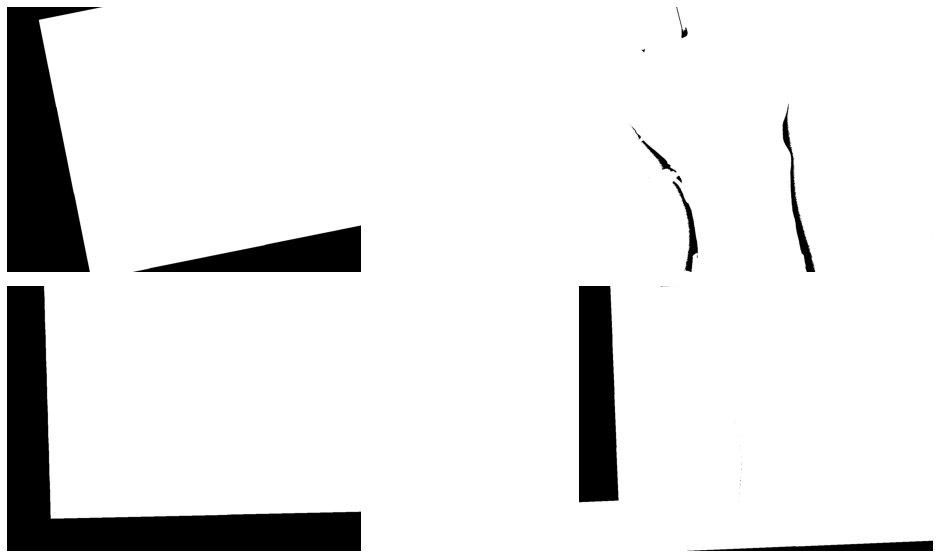

In [9]:
visualizeGenerator(train_aug_gen)

In [10]:
# model initialization
# load the VGG16 network, ensuring the head FC layers are left off
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(960, 1280, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training processr
resnet.trainable = False
# flatten the max-pooling output of VGG
flatten = resnet.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=resnet.input, outputs=bboxHead)

In [11]:
model.compile(loss="mse", optimizer='adam')

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("fold1_scaphoid_detection.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
batch_size = 4
n_epochs = 20
steps_per_epoch = 160// batch_size
validation_steps = 80 // batch_size

history = model.fit(x = train_aug_gen,
                validation_data = val_aug_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True,
                callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 20 steps
Epoch 1/20
 1/40 [..............................] - ETA: 9:31:51WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 